In [1]:
import numpy as np

import matplotlib.pyplot as plt

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y,  lw=1, label='Noise-free objective')
    plt.plot(X, mu, lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y,  lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()  

In [2]:
from scipy.stats import norm
import numpy as np
noise = 0.01
def made_v1(x1):
    loc1 = -2
    scale1 = 1.0
    
    loc2 = 3.5
    scale2 = 0.2
    
    def pdf_v1(x):
        return norm.pdf(x, loc=loc1, scale=scale1)*2
    
    def pdf_v2(x):
        return norm.pdf(x, loc=loc2, scale=scale2)
    
    mu,var = 0.0, 1e-2
    return (pdf_v2(x1) + pdf_v1(x1)) +  noise * np.random.randn(*x1.shape)

In [3]:
%matplotlib inline

bounds = np.array([[-5.0, 5.0]])


f = made_v1

X_init = np.array([[-2.9], [0.5],[-2.5],[2.3]])
Y_init = f(X_init)

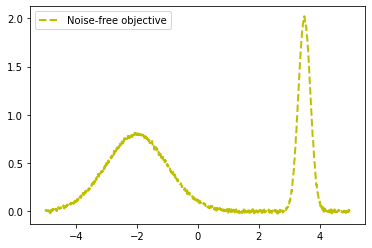

In [4]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
#plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
#plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [5]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.00):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.ravel()

In [6]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=10000):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x    
    
            
    return min_x.reshape(-1, 1)

In [7]:
np.random.uniform(bounds[:, 0], bounds[:, 1], size=(25, 1))

array([[ 3.59669252],
       [ 0.95642722],
       [ 1.8169039 ],
       [ 2.67884529],
       [-2.31743241],
       [ 4.39202155],
       [-4.79205582],
       [ 1.26942   ],
       [ 3.65595495],
       [-1.90907873],
       [-4.4946079 ],
       [ 0.95929469],
       [-0.46799428],
       [ 2.85130039],
       [ 0.49356123],
       [ 3.90262909],
       [ 3.57003898],
       [ 4.93066364],
       [ 4.76584982],
       [ 4.31491494],
       [ 1.20401983],
       [-2.68379372],
       [-4.08273172],
       [-4.15445654],
       [ 3.35328656]])

In [8]:
from scipy.optimize import minimize

def propose_location_with_acq_val(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    #for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
    xs = np.linspace(bounds[:,0], bounds[:,1],10000)
    best_acq_ind = np.argmin(min_obj(xs))
    x0 = xs[best_acq_ind]
    #for x0 in np.linspace(bounds[:,0], bounds[:,1], 10000):
    
        #res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        #if res.fun < min_val:
        #    min_val = res.fun[0]
        #    min_x = res.x           
        
    res = minimize(min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
    if(res.x < bounds[:,1] and res.x > bounds[:,0]):
        min_val = res.fun[0]
        min_x = res.x
    else:
        min_x = x0
        min_val = min_obj(x0)
    
            
    return min_x.reshape(-1, 1), min_val

-0.05522379661638191
-0.007251294992993417
-0.003771130447739246
[-0.0034149]
-0.002739112873372729
-0.0022570528823044845
-0.0019644183506248147
-0.0017624611461840374
-0.00161197739371558
-0.001494583886940854
-0.0013996709299796144
-0.0013208502999561048
-0.0012540586780940965
-0.0011961476420876064
-0.0011457649291919027
-0.0011012531686462994
-0.0010615954213128874
-0.001025853279989921
-0.0009942305486223425
-0.0009733699234527681
-0.0010053632026399894
-0.0009300125717511028
-0.0010301074435043775
-0.0008836276585177255
-0.0008505480941629069
-0.0008324563409972779
-0.0008245162460996509
-0.0009337768245550447
-0.0011625782890109346
-0.0016382191083682755


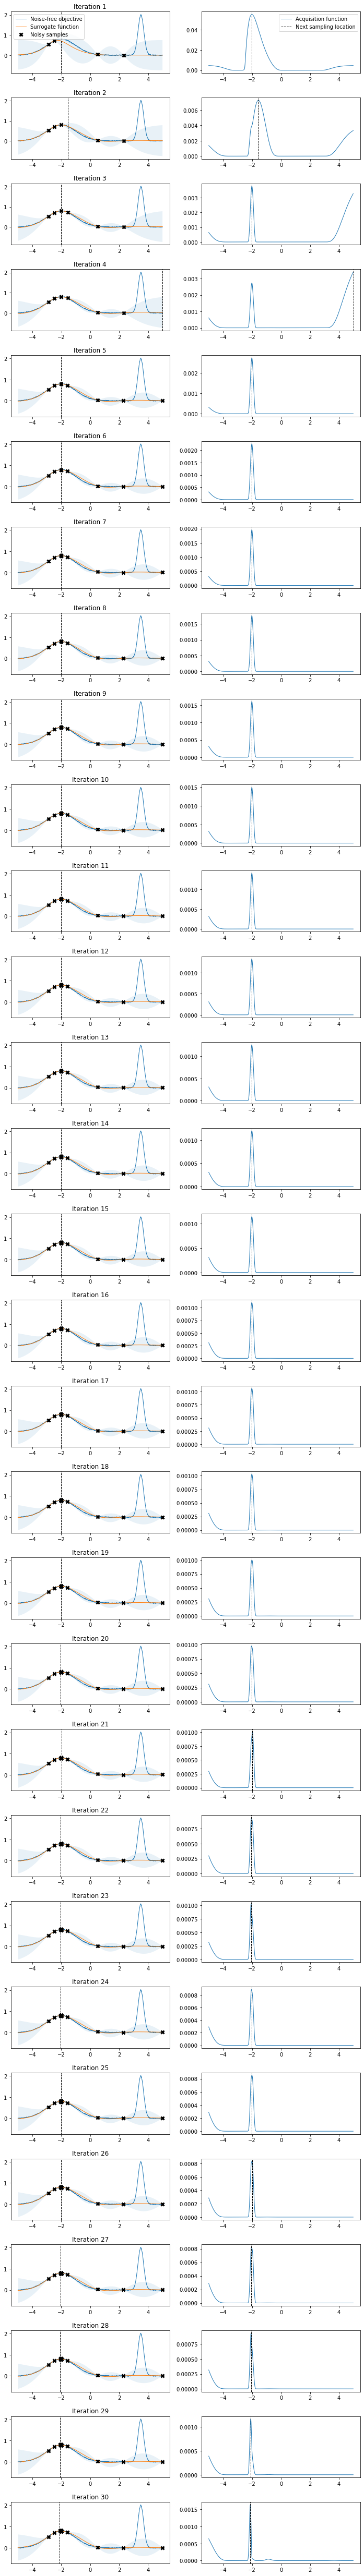

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
#from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next, acq_val = propose_location_with_acq_val(expected_improvement, X_sample, Y_sample, gpr, bounds)
    print(acq_val)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

In [10]:
X_init[X_init>0]

array([0.5, 2.3])

Iteration 1 sampled from 1 [[-1.28712871]]
Iteration 2 sampled from 2 [[0.07650765]]
Iteration 3 sampled from 1 [[-2.04132239]]
Iteration 4 sampled from 2 [[0.]]
Iteration 5 sampled from 1 [[-1.96208673]]
Iteration 6 sampled from 2 [[0.]]
Iteration 7 sampled from 1 [[-5.]]
Iteration 8 sampled from 2 [[0.]]
Iteration 9 sampled from 1 [[-1.97520854]]
Iteration 10 sampled from 2 [[0.]]
Iteration 11 sampled from 1 [[-1.98142804]]
Iteration 12 sampled from 2 [[5.]]
Iteration 13 sampled from 1 [[-1.95969595]]
Iteration 14 sampled from 2 [[0.]]
Iteration 15 sampled from 1 [[-1.98019802]]
Iteration 16 sampled from 2 [[0.]]
Iteration 17 sampled from 1 [[-1.98575206]]
Iteration 18 sampled from 2 [[0.]]
Iteration 19 sampled from 1 [[-1.98719873]]
Iteration 20 sampled from 2 [[0.]]
Iteration 21 sampled from 1 [[-1.98719872]]
Iteration 22 sampled from 2 [[0.]]
Iteration 23 sampled from 1 [[-1.98769873]]
Iteration 24 sampled from 2 [[0.]]
Iteration 25 sampled from 1 [[-1.98576131]]
Iteration 26 samp

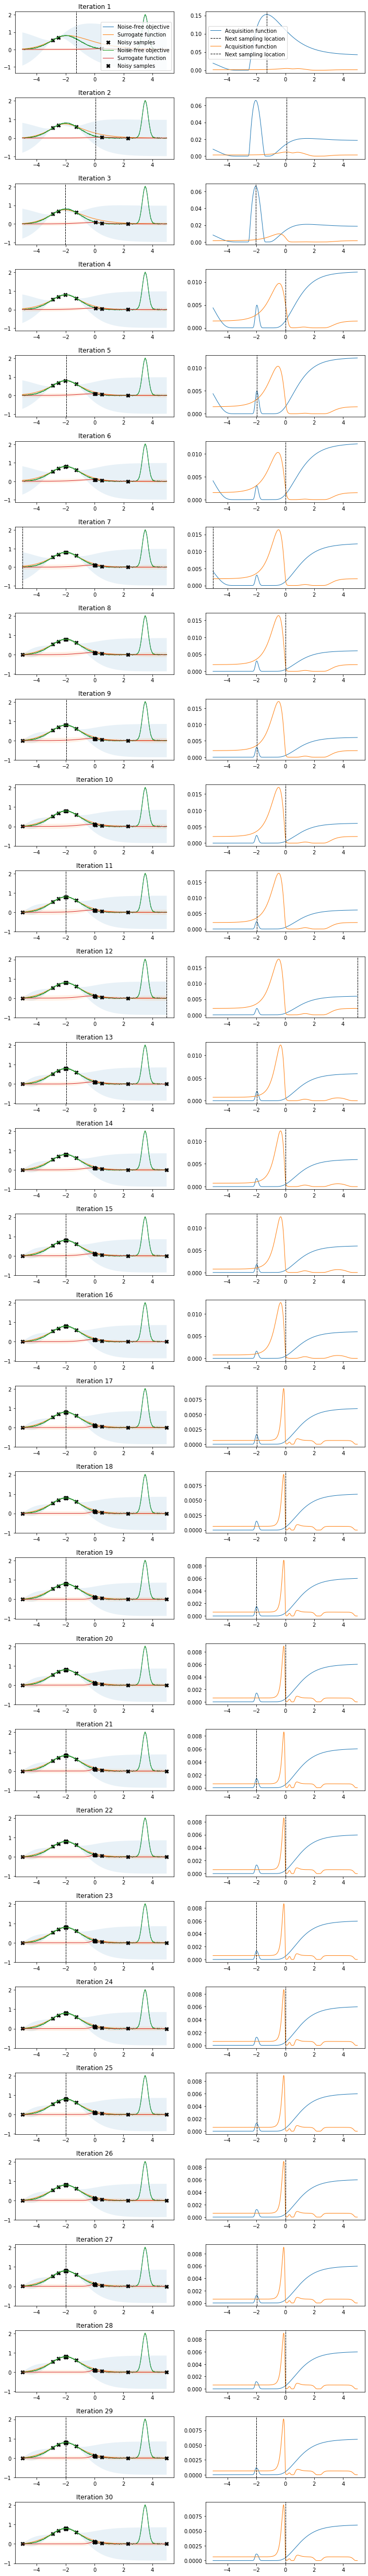

In [11]:
# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

m52_2 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr_2 = GaussianProcessRegressor(kernel=m52_2, alpha=noise**2)

# Initialize samples
X_sample_1 = X_init[X_init <0].reshape(-1,1)
Y_sample_1 = f(X_sample_1)
bounds_1 = np.array([[-5.0, 0.0]])

X_sample_2 = X_init[X_init >= 0].reshape(-1,1)
Y_sample_2 = f(X_sample_2)
bounds_2 = np.array([[0.0, 5.0]])

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample_1, Y_sample_1)
    gpr_2.fit(X_sample_2, Y_sample_2)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next_1, acq_val_1 = propose_location_with_acq_val(expected_improvement, X_sample_1, Y_sample_1, gpr, bounds_1)
    
    X_next_2, acq_val_2 = propose_location_with_acq_val(expected_improvement, X_sample_2, Y_sample_2, gpr_2, bounds_2)
    
    
    
    
    X_next = X_next_1 if i%2 == 0 else X_next_2
    num = 1 if i%2==0 else 2
    Y_next = f(X_next)
    
    # Obtain next noisy sample from the objective function
    print("Iteration",(i+1),"sampled from",num,"%s"%str(X_next))
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample_1, Y_sample_1, X_next, show_legend=i==0)
    plot_approximation(gpr_2, X, Y, X_sample_2, Y_sample_2, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample_1, Y_sample_1, gpr), X_next, show_legend=i==0)
    plot_acquisition(X, expected_improvement(X, X_sample_2, Y_sample_2, gpr_2), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    #X_sample = np.vstack((X_sample, X_next))
    #Y_sample = np.vstack((Y_sample, Y_next))
    if(num == 1):
        X_sample_1 = np.vstack((X_sample_1, X_next))
        Y_sample_1 = np.vstack((Y_sample_1, Y_next))
    else:
        X_sample_2 = np.vstack((X_sample_2, X_next))
        Y_sample_2 = np.vstack((Y_sample_2, Y_next))

In [12]:
from scipy.stats import norm
import numpy as np
noise = 0.01
def made_v2(x1):
    loc1 = -2
    scale1 = 1.0
    
    loc2 = 3.5
    scale2 = 0.2
    
    def pdf_v1(x):
        return norm.pdf(x, loc=loc1, scale=scale1)*3
    
    def pdf_v2(x):
        return norm.pdf(x, loc=loc2, scale=scale2)
    
    mu,var = 0.0, 1e-2
    return (pdf_v2(x1) + pdf_v1(x1)) +  noise * np.random.randn(*x1.shape)

In [13]:
%matplotlib inline

bounds = np.array([[-5.0, 5.0]])


f = made_v2

X_init = np.array([[-2.9], [0.5],[-2.5],[2.3]])
Y_init = f(X_init)

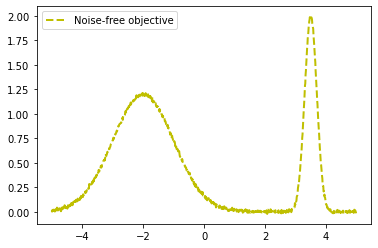

In [14]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
#plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
#plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [15]:
import sklearn.gaussian_process.kernels

iteration 0 -0.08429828994432868
{'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
iteration 1 [-0.00516539]
{'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
iteration 2 -0.004330403309931758
{'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(lengt

iteration 21 -0.0008872975929994149
{'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
iteration 22 -0.0008732393184655863
{'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
iteration 23 -0.0008996131111617103
{'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel_

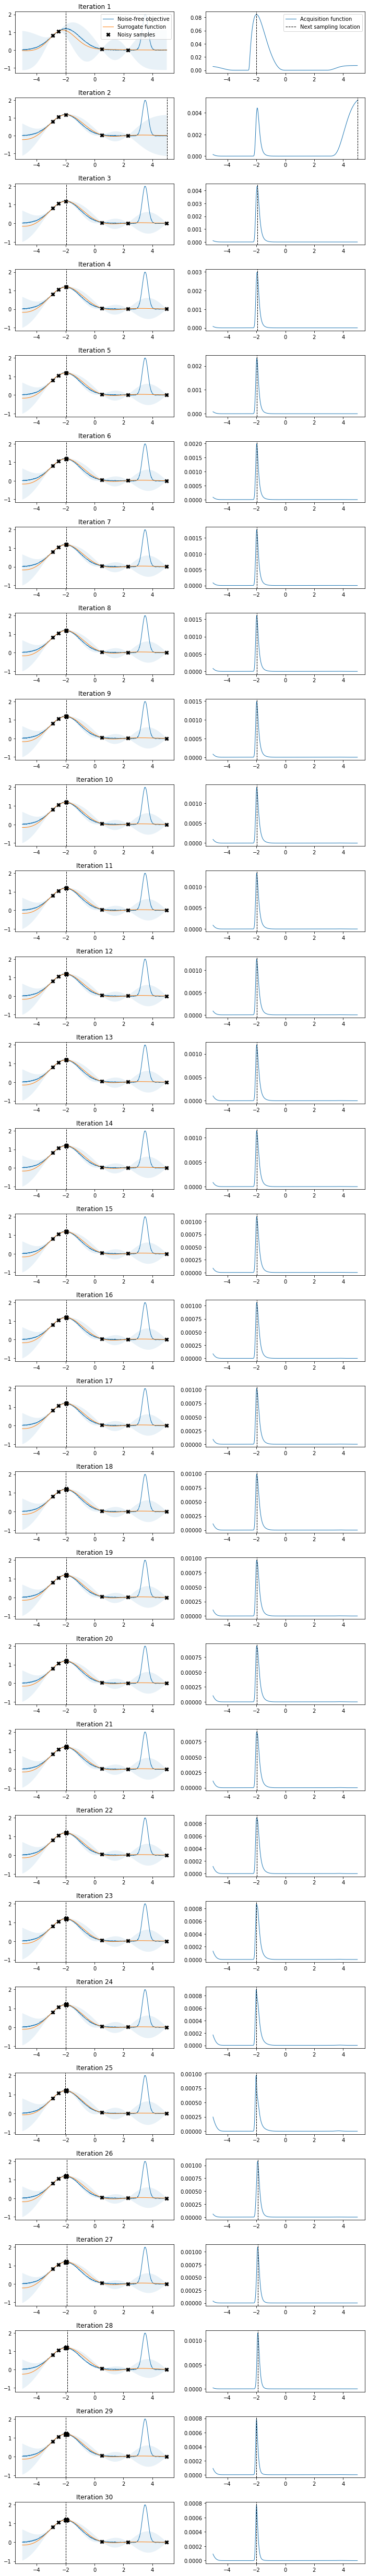

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF
#from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * RBF(length_scale=1.0)
#m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next, acq_val = propose_location_with_acq_val(expected_improvement, X_sample, Y_sample, gpr, bounds)
    print("iteration",i,acq_val)
    print(gpr.get_params())
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Iteration 1 sampled from 1 [[-1.44509729]]
Iteration 2 sampled from 2 [[0.3050305]]
Iteration 3 sampled from 1 [[-2.03999373]]
Iteration 4 sampled from 2 [[0.]]
Iteration 5 sampled from 1 [[-2.02676582]]
Iteration 6 sampled from 2 [[0.]]
Iteration 7 sampled from 1 [[-2.02877215]]
Iteration 8 sampled from 2 [[0.]]
Iteration 9 sampled from 1 [[-2.02795232]]
Iteration 10 sampled from 2 [[1.19611961]]
Iteration 11 sampled from 1 [[-2.03282962]]
Iteration 12 sampled from 2 [[5.]]
Iteration 13 sampled from 1 [[-2.02960928]]
Iteration 14 sampled from 2 [[0.]]
Iteration 15 sampled from 1 [[-2.03020296]]
Iteration 16 sampled from 2 [[0.]]
Iteration 17 sampled from 1 [[-2.0292029]]
Iteration 18 sampled from 2 [[0.]]
Iteration 19 sampled from 1 [[-2.02983194]]
Iteration 20 sampled from 2 [[0.]]
Iteration 21 sampled from 1 [[-2.03220331]]
Iteration 22 sampled from 2 [[0.]]
Iteration 23 sampled from 1 [[-2.03189773]]
Iteration 24 sampled from 2 [[0.]]
Iteration 25 sampled from 1 [[-2.0305836]]
Iter

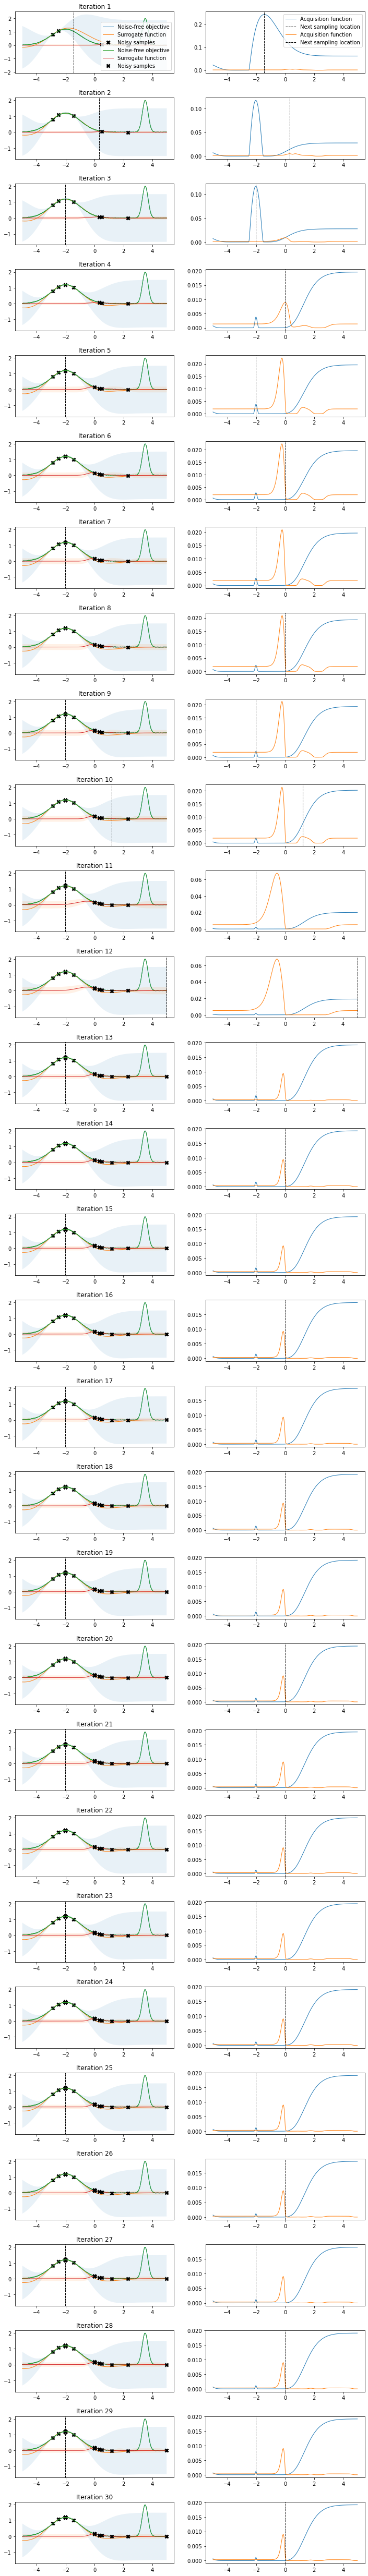

In [17]:
# Gaussian process with Mat??rn kernel as surrogate model
#m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
m52 = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

#m52_2 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
m52_2 = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr_2 = GaussianProcessRegressor(kernel=m52_2, alpha=noise**2)

# Initialize samples
X_sample_1 = X_init[X_init <0].reshape(-1,1)
Y_sample_1 = f(X_sample_1)
bounds_1 = np.array([[-5.0, 0.0]])

X_sample_2 = X_init[X_init >= 0].reshape(-1,1)
Y_sample_2 = f(X_sample_2)
bounds_2 = np.array([[0.0, 5.0]])

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample_1, Y_sample_1)
    gpr_2.fit(X_sample_2, Y_sample_2)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next_1, acq_val_1 = propose_location_with_acq_val(expected_improvement, X_sample_1, Y_sample_1, gpr, bounds_1)
    
    X_next_2, acq_val_2 = propose_location_with_acq_val(expected_improvement, X_sample_2, Y_sample_2, gpr_2, bounds_2)
    
    
    
    
    X_next = X_next_1 if i%2 == 0 else X_next_2
    num = 1 if i%2==0 else 2
    Y_next = f(X_next)
    
    # Obtain next noisy sample from the objective function
    print("Iteration",(i+1),"sampled from",num,"%s"%str(X_next))
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample_1, Y_sample_1, X_next, show_legend=i==0)
    plot_approximation(gpr_2, X, Y, X_sample_2, Y_sample_2, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample_1, Y_sample_1, gpr), X_next, show_legend=i==0)
    plot_acquisition(X, expected_improvement(X, X_sample_2, Y_sample_2, gpr_2), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    #X_sample = np.vstack((X_sample, X_next))
    #Y_sample = np.vstack((Y_sample, Y_next))
    if(num == 1):
        X_sample_1 = np.vstack((X_sample_1, X_next))
        Y_sample_1 = np.vstack((Y_sample_1, Y_next))
    else:
        X_sample_2 = np.vstack((X_sample_2, X_next))
        Y_sample_2 = np.vstack((Y_sample_2, Y_next))

In [18]:
type(gpr.get_params())

dict

In [19]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.ravel()

-0.07876206217307137
-0.005313692876832067
[-0.00503154]
-0.000963617556565827
[-0.00040996]
-0.0002615534019388894
-0.00010504933284972404
-5.28652658819287e-05
-3.0625212915684296e-05
-4.848405629685835e-05
-1.6919694000957063e-05
-6.543294745260474e-06
-2.3750427622776837e-06
-2.933104491088122e-06
-4.239071985325976e-06
-4.428534277070738e-06
-1.1330105480236438e-06
-5.475892577849801e-07
-2.722335105797906e-07
-1.0345888323540144e-07
-8.208664918176775e-08
-3.707417331381559e-08
-2.300998497292829e-08
-1.6686987950620473e-08
-1.43804478814591e-08
-7.491865470846675e-09
-4.8283912189940265e-09
-0.01172614093084276
-0.29752357343181984
-0.005125895307212661


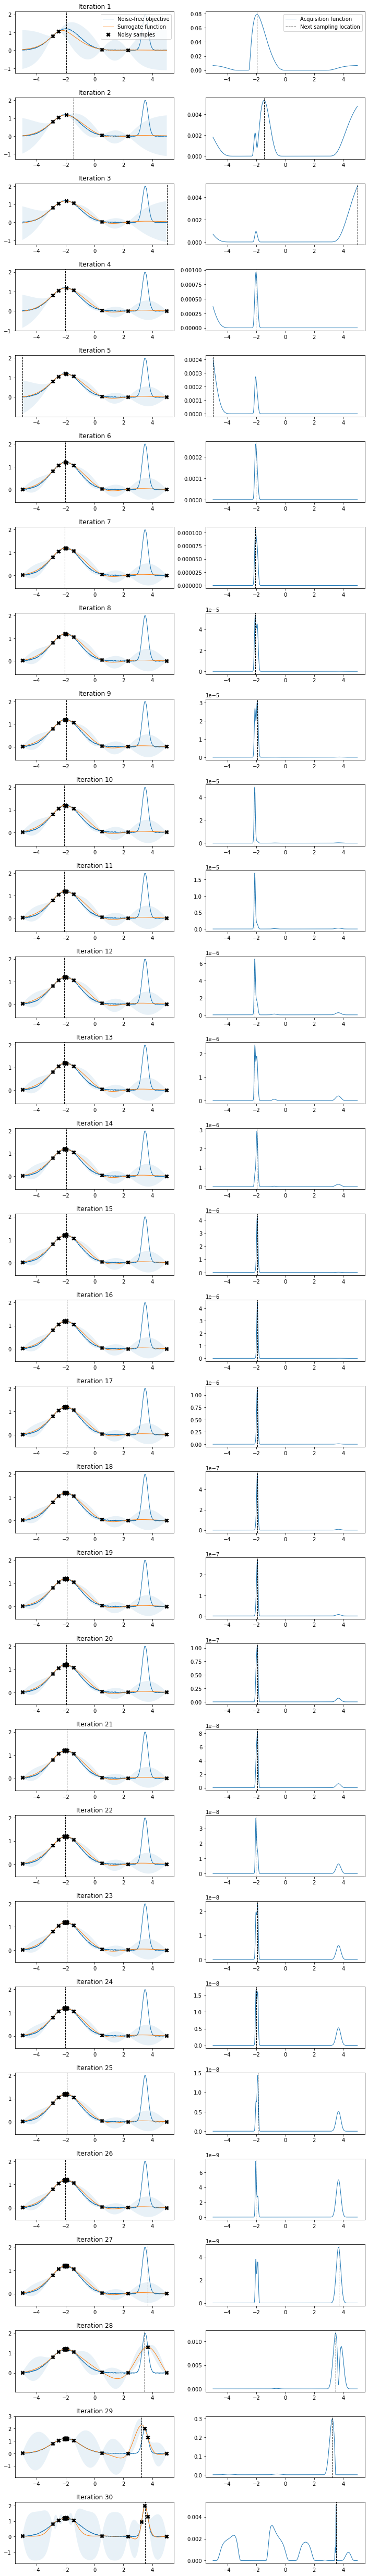

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
#from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next, acq_val = propose_location_with_acq_val(expected_improvement, X_sample, Y_sample, gpr, bounds)
    print(acq_val)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Iteration 1 sampled from 1 [[-1.4026625]]
Iteration 2 sampled from 2 [[0.3520352]]
Iteration 3 sampled from 1 [[-2.02928875]]
Iteration 4 sampled from 2 [[0.18903363]]
Iteration 5 sampled from 1 [[0.]]
Iteration 6 sampled from 2 [[0.00122635]]
Iteration 7 sampled from 1 [[-5.]]
Iteration 8 sampled from 2 [[5.]]
Iteration 9 sampled from 1 [[-1.96666853]]
Iteration 10 sampled from 2 [[0.]]
Iteration 11 sampled from 1 [[-1.94019395]]
Iteration 12 sampled from 2 [[3.69336934]]
Iteration 13 sampled from 1 [[-1.90155887]]
Iteration 14 sampled from 2 [[3.45782532]]
Iteration 15 sampled from 1 [[-2.02320231]]
Iteration 16 sampled from 2 [[3.26184134]]
Iteration 17 sampled from 1 [[-2.04370474]]
Iteration 18 sampled from 2 [[3.50676945]]
Iteration 19 sampled from 1 [[-2.0387422]]
Iteration 20 sampled from 2 [[3.50361131]]
Iteration 21 sampled from 1 [[-1.9151912]]
Iteration 22 sampled from 2 [[1.42314231]]
Iteration 23 sampled from 1 [[-1.90928782]]
Iteration 24 sampled from 2 [[3.49546832]]
It

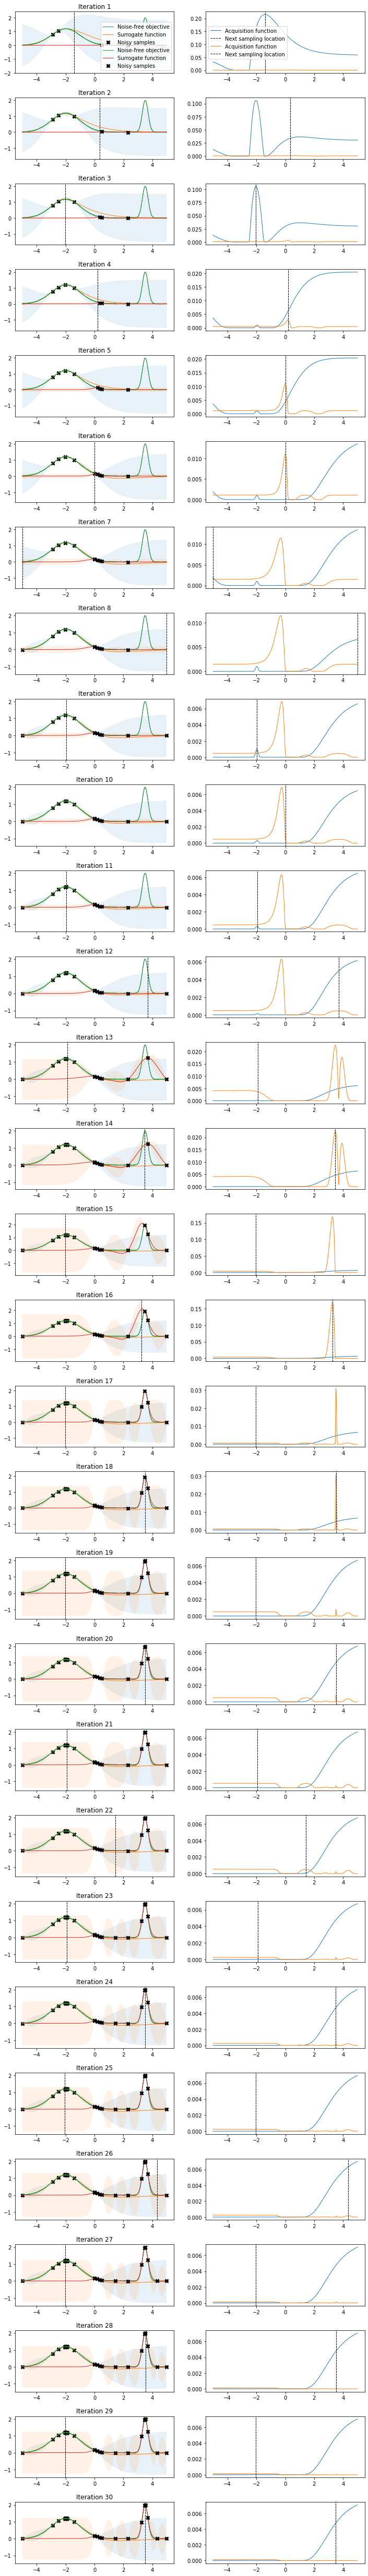

In [21]:
# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

m52_2 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr_2 = GaussianProcessRegressor(kernel=m52_2, alpha=noise**2)

# Initialize samples
X_sample_1 = X_init[X_init <0].reshape(-1,1)
Y_sample_1 = f(X_sample_1)
bounds_1 = np.array([[-5.0, 0.0]])

X_sample_2 = X_init[X_init >= 0].reshape(-1,1)
Y_sample_2 = f(X_sample_2)
bounds_2 = np.array([[0.0, 5.0]])

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample_1, Y_sample_1)
    gpr_2.fit(X_sample_2, Y_sample_2)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next_1, acq_val_1 = propose_location_with_acq_val(expected_improvement, X_sample_1, Y_sample_1, gpr, bounds_1)
    
    X_next_2, acq_val_2 = propose_location_with_acq_val(expected_improvement, X_sample_2, Y_sample_2, gpr_2, bounds_2)
    
    
    
    
    X_next = X_next_1 if i%2 == 0 else X_next_2
    num = 1 if i%2==0 else 2
    Y_next = f(X_next)
    
    # Obtain next noisy sample from the objective function
    print("Iteration",(i+1),"sampled from",num,"%s"%str(X_next))
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample_1, Y_sample_1, X_next, show_legend=i==0)
    plot_approximation(gpr_2, X, Y, X_sample_2, Y_sample_2, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample_1, Y_sample_1, gpr), X_next, show_legend=i==0)
    plot_acquisition(X, expected_improvement(X, X_sample_2, Y_sample_2, gpr_2), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    #X_sample = np.vstack((X_sample, X_next))
    #Y_sample = np.vstack((Y_sample, Y_next))
    if(num == 1):
        X_sample_1 = np.vstack((X_sample_1, X_next))
        Y_sample_1 = np.vstack((Y_sample_1, Y_next))
    else:
        X_sample_2 = np.vstack((X_sample_2, X_next))
        Y_sample_2 = np.vstack((Y_sample_2, Y_next))